# install transformer and arabert from huggingface

In [1]:
pip install transformers #install transformer from hugging face

In [2]:
pip install arabert # install arabert

In [3]:
!pip install farasapy

# import libraries and models

In [4]:

import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

from transformers import AutoTokenizer, TFBertForSequenceClassification
import tensorflow as tf
tf.random.set_seed(42) # To fix the intiallization



# Load the pre-trained model and tokenizer


In [5]:
#load tokenizer and model from huggingface
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model_1 = TFBertForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02",num_labels =2) # dataset has three labels (positive ,nuetral and negative)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
#import preprocessing library
from arabert.preprocess import ArabertPreprocessor

model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

[2023-10-09 07:33:40,265 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


# load dataset and check it


In [7]:
data =pd.read_csv("CompanyReviews.csv" ,encoding="utf-8") #dataset  from kaggle


In [8]:
data

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat
...,...,...,...,...
40041,128,تجربه جيده بس ينقصها عدم اهتمام خدمة العملاء ب...,0,swvl
40042,129,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل ال...,-1,swvl
40043,130,جيد ولكن لماذا لا توجد خطوط كثيره من المريوطيه...,0,swvl
40044,131,جيدا جدا ...ولكن الاسعار عاليه جدا\n,0,swvl


In [9]:
data.drop(columns=["Unnamed: 0"])


,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat
...,...,...,...
40041,تجربه جيده بس ينقصها عدم اهتمام خدمة العملاء ب...,0,swvl
40042,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل ال...,-1,swvl
40043,جيد ولكن لماذا لا توجد خطوط كثيره من المريوطيه...,0,swvl
40044,جيدا جدا ...ولكن الاسعار عاليه جدا\n,0,swvl


In [10]:
data=data[data.rating != 0]


In [11]:
data

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat
...,...,...,...,...
40028,115,الابليكيشن يدخلنا فى متاهات لا نفهم منها شيء ....,-1,swvl
40029,116,تجربة سيئة جدا منصحش اى حد بتحميل التطبيق النظ...,-1,swvl
40035,122,بعد ما اخدت الباقة الاولى ب ١٦٠ جنيه ٣٠ رحلة ب...,-1,swvl
40037,124,الخدمة جيدة ولكن يرجى تعديل سلوك بعض السائقين ...,1,swvl


In [12]:
data.info() #check dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38121 entries, 0 to 40042
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          38121 non-null  int64 
 1   review_description  38120 non-null  object
 2   rating              38121 non-null  int64 
 3   company             38121 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [13]:
data.describe()

,Unnamed: 0,rating
count,38121.000000,38121.000000
mean,19413.170929,0.255004
std,11554.194614,0.966953
min,0.000000,-1.000000
25%,9415.000000,-1.000000
50%,19249.000000,1.000000
75%,29434.000000,1.000000
max,39540.000000,1.000000


In [14]:
print(data.isnull().sum()) #check for nulls

Unnamed: 0            0
review_description    1
rating                0
company               0
dtype: int64


In [15]:
data.dropna(inplace=True)# remove nulls
data = data.reset_index(drop=True) # to update index on new dataset

# data.dropna(subset=['review_description'], inplace=True)
print(data.isnull().sum()) # check for nulls again

Unnamed: 0            0
review_description    0
rating                0
company               0
dtype: int64


<ipython-input-15-6c2c9aea4759>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)# remove nulls


In [16]:
data

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat
...,...,...,...,...
38115,115,الابليكيشن يدخلنا فى متاهات لا نفهم منها شيء ....,-1,swvl
38116,116,تجربة سيئة جدا منصحش اى حد بتحميل التطبيق النظ...,-1,swvl
38117,122,بعد ما اخدت الباقة الاولى ب ١٦٠ جنيه ٣٠ رحلة ب...,-1,swvl
38118,124,الخدمة جيدة ولكن يرجى تعديل سلوك بعض السائقين ...,1,swvl


In [17]:
duplicated_reviews=data.review_description.duplicated().sum() #check for duplication reviews

In [18]:
print(duplicated_reviews)

1006


In [19]:
data.drop(data[data.review_description.duplicated() == True].index, axis = 0, inplace = True) #drop duplicated reviews


In [20]:
duplicated_reviews=data.review_description.duplicated().sum() #check for duplication reviews
print(duplicated_reviews)

0


In [21]:
data

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat
...,...,...,...,...
38115,115,الابليكيشن يدخلنا فى متاهات لا نفهم منها شيء ....,-1,swvl
38116,116,تجربة سيئة جدا منصحش اى حد بتحميل التطبيق النظ...,-1,swvl
38117,122,بعد ما اخدت الباقة الاولى ب ١٦٠ جنيه ٣٠ رحلة ب...,-1,swvl
38118,124,الخدمة جيدة ولكن يرجى تعديل سلوك بعض السائقين ...,1,swvl


In [22]:
data.dropna(inplace=True)# remove nulls
data = data.reset_index(drop=True) # to update index on new dataset

In [23]:
data

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat
...,...,...,...,...
37109,115,الابليكيشن يدخلنا فى متاهات لا نفهم منها شيء ....,-1,swvl
37110,116,تجربة سيئة جدا منصحش اى حد بتحميل التطبيق النظ...,-1,swvl
37111,122,بعد ما اخدت الباقة الاولى ب ١٦٠ جنيه ٣٠ رحلة ب...,-1,swvl
37112,124,الخدمة جيدة ولكن يرجى تعديل سلوك بعض السائقين ...,1,swvl


In [24]:
review_rate=data['rating'].value_counts() #check  count for each rate

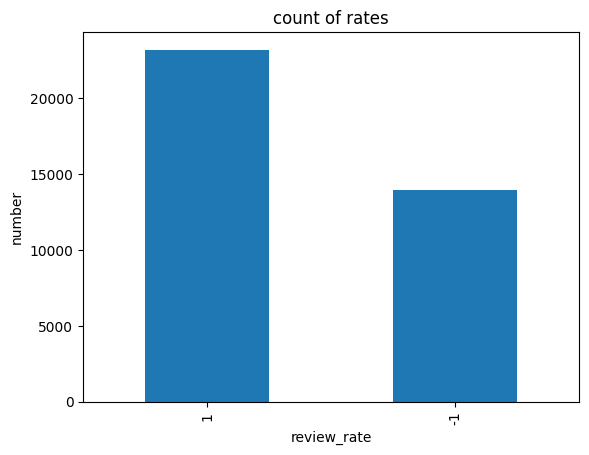

In [25]:
import matplotlib.pyplot as plt
plt.figure()  # Adjust the figure size
review_rate.plot(kind='bar')
plt.xlabel('review_rate')
plt.ylabel('number')
plt.title('count of rates')
plt.show()

In [26]:
#splitting train dataset to train and validation sets
train_data=data['review_description']
train_text=train_data[:10000]
train_text.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: review_description
Non-Null Count  Dtype 
--------------  ----- 
10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [27]:
ratingsDict = {-1:0,
1:1  }
data['rating'] = data['rating'].apply(lambda x: ratingsDict[x])# convert labels to integers
train_labels=data['rating']
train_labels=train_labels[:10000]


In [28]:
train_labels

0       1
1       1
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    0
9999    1
Name: rating, Length: 10000, dtype: int64

In [29]:
print(type(train_text))
print(type(train_labels))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [30]:
#convert labels to tensors
train_labels = tf.constant(train_labels)

In [31]:
# new_train_text = train_text.apply(lambda x: arabert_prep.preprocess(x))


In [32]:
# new_train_text[:10]#check train text after applying arabert preprocessing

# cleaning data and preprocessing

In [33]:
def tokenization(data) :
  data = data.values.tolist() #convert data text to list
  data_encodings = tokenizer(data, truncation=True,padding="max_length", max_length=15) # Tokenize the data  texts
  data_input_ids = tf.constant(data_encodings['input_ids'])  # Convert input encodings to tensors
  data_attention_mask = tf.constant(data_encodings['attention_mask'])
  return data_input_ids , data_attention_mask

In [34]:
train_input_ids,train_attention_mask=tokenization(train_text) #apply tokenization function
print(type(train_input_ids))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [35]:
train_input_ids #check train_input_ids

<tf.Tensor: shape=(10000, 15), dtype=int32, numpy=
array([[    2, 13149,     3, ...,     0,     0,     0],
       [    2,  1671, 13149, ...,     0,     0,     0],
       [    2, 11818,   391, ..., 44411,    20,     3],
       ...,
       [    2,  2365, 13149, ...,     0,     0,     0],
       [    2,   418, 29132, ...,     0,     0,     0],
       [    2,   589,  1800, ...,     0,     0,     0]], dtype=int32)>

In [36]:
#  to check sparsity in train_input_ids
num_zeros_1 = tf.math.count_nonzero(tf.equal(train_input_ids, 0))

# Execute the computation
num_zeros_value_1 = num_zeros_1.numpy()


print("Number of zeros:", num_zeros_value_1)

Number of zeros: 48209


In [37]:
train_attention_mask #check train_attention_mask

<tf.Tensor: shape=(10000, 15), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [38]:
#  to check sparsity in train_attention_mask
num_zeros_2 = tf.math.count_nonzero(tf.equal(train_attention_mask, 0))

# Execute the computation
num_zeros_value_2 = num_zeros_2.numpy()

print("Number of zeros:", num_zeros_value_2)

Number of zeros: 48209


# Train model


In [39]:
# model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), # set learning rate 1e-5
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # use SparseCategoricalCrossentropy as loss function
#               metrics=['accuracy']) # use accuracy as metrics

In [40]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(data['rating']),y=data['rating']
                                                )

In [41]:
class_weights


array([1.33177838, 0.80056083])

In [42]:
dropout_rate = 0.2
class_weight = {0: 3,
                1: 1
                     }  # Specify the dropout rate you want to use

# Access the base BERT model within the sequence classification model
base_model = model_1.bert

# Add dropout layer after the embedding layer
base_model.embeddings.dropout = tf.keras.layers.Dropout(dropout_rate)

# Add dropout layer after the encoder layers
for layer in base_model.encoder.layer:
    layer.attention.output_dropout = tf.keras.layers.Dropout(dropout_rate)
    layer.output_dropout = tf.keras.layers.Dropout(dropout_rate)

# Compile and train the model as usual
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), # set learning rate 1e-5
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # use SparseCategoricalCrossentropy as loss function
              metrics=['accuracy'])
history=model_1.fit([train_input_ids, train_attention_mask], train_labels, batch_size=128, epochs=50,
                    validation_split=0.3,shuffle=True,class_weight=class_weight)

Epoch 1/50
55/55 [==============================] - 103s 622ms/step - loss: 1.0325 - accuracy: 0.6223 - val_loss: 0.9009 - val_accuracy: 0.4877
Epoch 2/50
55/55 [==============================] - 30s 541ms/step - loss: 0.9356 - accuracy: 0.6236 - val_loss: 0.8581 - val_accuracy: 0.4900
Epoch 3/50
55/55 [==============================] - 28s 517ms/step - loss: 0.8782 - accuracy: 0.6236 - val_loss: 0.8069 - val_accuracy: 0.4877
Epoch 4/50
55/55 [==============================] - 28s 518ms/step - loss: 0.8181 - accuracy: 0.6284 - val_loss: 0.7455 - val_accuracy: 0.4880
Epoch 5/50
55/55 [==============================] - 28s 511ms/step - loss: 0.7642 - accuracy: 0.6349 - val_loss: 0.6799 - val_accuracy: 0.5027
Epoch 6/50
55/55 [==============================] - 27s 493ms/step - loss: 0.7040 - accuracy: 0.6656 - val_loss: 0.6295 - val_accuracy: 0.5970
Epoch 7/50
55/55 [==============================] - 28s 508ms/step - loss: 0.6574 - accuracy: 0.7169 - val_loss: 0.5893 - val_accuracy: 0.731

In [43]:
# Train the model
# history = model.fit([train_input_ids, train_attention_mask], train_labels, batch_size=64, epochs=10,
#                     validation_split=0.3,shuffle=True)

In [44]:
# history = model.fit([train_input_ids, train_attention_mask], train_labels, batch_size=64, epochs=10,
#                     validation_split=0.3,shuffle=True)

In [45]:
model_1.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  135193344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 135194882 (515.73 MB)
Trainable params: 135194882 (515.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Text(0.5, 1.0, 'loss')

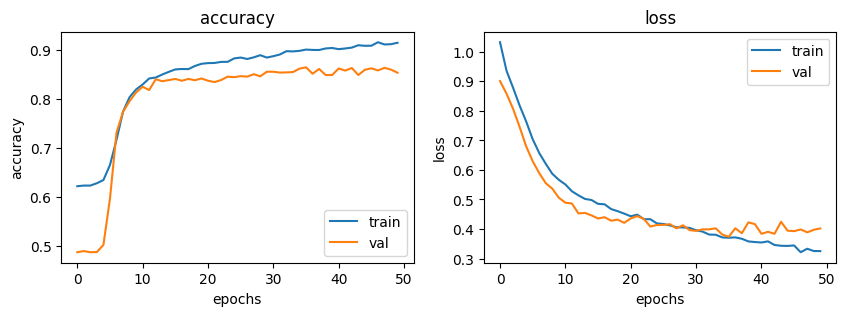

In [46]:

# import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

for i, j in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[j])
    ax[i].plot(history.history['val_' + j])
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(j)
    ax[i].legend(['train', 'val'])

ax[0].set_title('accuracy')
ax[1].set_title('loss')

# test model

In [47]:
test_data=data[20000:25000]
test_text=test_data["review_description"]
# new_test_text=test_text.apply(lambda y: arabert_prep.preprocess(y))
test_input_ids,test_attention_mask=tokenization(test_text)


In [48]:
predictions = model_1.predict([test_input_ids, test_attention_mask])
predicted_labels = tf.argmax(predictions.logits, axis=1)


predicted_labels

157/157 [==============================] - 11s 55ms/step


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([1, 1, 1, ..., 0, 1, 1])>

In [49]:
test_labels=test_data['rating']

In [50]:
#convert labels to tensors
test_labels = tf.constant(test_labels)

In [51]:
from sklearn.metrics import classification_report

y_true = test_labels # True labels of your test dataset
y_pred = predicted_labels # Predicted labels from your fine-tuned model


# Calculate the evaluation metrics
classification_report = classification_report(y_true, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.53      0.90      0.67       960
           1       0.97      0.81      0.88      4040

    accuracy                           0.83      5000
   macro avg       0.75      0.86      0.78      5000
weighted avg       0.89      0.83      0.84      5000



# save model

In [52]:
# model.save("arabic_review_sentence_analysis_using_AraBERT.tf")

In [53]:
# model.save_weights("arabic_review.ckpt")

In [54]:
# from google.colab import files

# files.download('arabic_review_sentence_analysis_using_bert.tf')